## Nonlinear biomechanical model
A biomechanical model simulating the mouse ankle joint with a nonlinear muscle model. Model parameters of the skeletal segment are estimated based on the mouse forelimb. Joint excursion is constrained by exponential elastic stops. Small viscosity is added to improve the stability of the system, which is necessary for the elastic stops to work appropriately. Nonlinear properties of muscle are introduced to prevent the system from drifting when there is an offset between the flexor and extensor activities. 

### Import Libraries

In [339]:
import time
import torch
import numpy as np
import matplotlib.pyplot as plt
device = 'cpu'

### Define muscle model functions 
* FL: force-legnth relationship
* FV: force-velocity relationship
* Fpe: passive elastic force

In [340]:
def FL_function(L):
    beta = 1.55
    omega = 0.75
    rho = 2.12
    
    FL = np.exp(-np.power(abs((np.power(L,beta) - 1)/(omega)),rho));
    return FL

In [341]:
def FV_con_function(L,V):
    Vmax = -9.15*2;
    cv0 = -5.7;
    cv1 = 9.18;
    
    FVcon = (Vmax - V)/(Vmax + (cv0 + cv1*L)*V);
    return FVcon

In [342]:
def FV_ecc_function(L,V):
    av0 = -1.4;
    av1 = 0.0;
    av2 = 0.0;
    bv = 0.72;
    FVecc = (bv - (av0 + av1*L + av2*np.power(L,2))*V)/(bv+V);
    
    return FVecc

In [343]:
def Fpe_function(L,V):
    c1_pe1 = 23.0*6
    k1_pe1 = 0.046
    Lr1_pe1 = 1.17
    eta = 0.0001;
    
    Fpe1 = c1_pe1 * k1_pe1 * np.log(np.exp((L - Lr1_pe1)/(k1_pe1))+1) + eta*V;
    
    return Fpe1

In [358]:
def forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2):
    # Minimum joint angle
    theta_min = 40*np.pi/180.0
    # Maximum joint angle
    theta_max = 110*np.pi/180.0
    
    Lce_1 = x[2]/Lce0_1
    Lce_2 = x[3]/Lce0_2
    Vce_1 = -r_m1*x[1]/Lce0_1
    Vce_2 = -r_m2*x[1]/Lce0_2
    
    FL_1 = FL_function(Lce_1)
    FL_2 = FL_function(Lce_1)
    
    if Vce_1 <= 0:
        FV_1 = FV_con_function(Lce_1,Vce_1)
    else:
        FV_1 = FV_ecc_function(Lce_1,Vce_1)
    if Vce_2 <= 0:
        FV_2 = FV_con_function(Lce_2,Vce_2)
    else:
        FV_2 = FV_ecc_function(Lce_2,Vce_2)
        
    Fpe_1 = Fpe_function(Lce_1/Lmax_1,Vce_1)
    Fpe_2 = Fpe_function(Lce_2/Lmax_2,Vce_2)
    
    Fm_1 = (FL_1*FV_1*u[0]+Fpe_1)*F0_1
    Fm_2 = (FL_2*FV_2*u[1]+Fpe_2)*F0_2
        
    T_stop_1 = 0.01*np.exp(-(x[0]-theta_min)/0.01)
    T_stop_2 = -0.01*np.exp((x[0]-theta_max)/0.01)
    
    dx[0] = x[1]
    dx[1] = (Fm_1*r_m1 + Fm_2*r_m2 + T_stop_1 + T_stop_2)/I - B*x[1] - K*x[0]
    dx[2] = -r_m1*x[1]
    dx[3] = -r_m2*x[1]
    return dx

## Define simulation parameters 

In [345]:
Fs = 10000
h = 1/Fs
duration = 1

### Define inputs 
* u_1: input to dorsilexors (i.e. TA, EDL, EHL) 
* u_2: input to plantarflexors (i.e., MG, LG, SO, PL, FDL, TP)

In [346]:
# Set the amplitude of step inputs
u_1_amp = 0.1
u_2_amp = 0.0

# Generate step inputs to flexor and extensor
time_sim = np.arange(0,duration,step = 1/Fs)
u_1 = np.zeros([int(duration*Fs),1])
u_2 = np.zeros([int(duration*Fs),1])
u_1[int(0.1*Fs):] = u_1_amp
u_2[int(0.1*Fs):] = u_2_amp

### Define parameters of the biomechanical model

In [347]:
# Segment length
L = 0.03 
# Distance between the rotational axis and the center of the segment 
d = 0
# Segment mass
M = 0.0004
# Segment inertia
I = 1/12.0*np.power(L,2)*M + np.power(d,2)*M
# Stiffness
K = 0.0
# Viscosity 
B = 0.0001

# Minimum joint angle
theta_min = 40*np.pi/180.0
# Maximum joint angle
theta_max = 110*np.pi/180.0
# Positive angle change => dorsiflexion 

* Muscle 1: dorsilexors (i.e. TA, EDL, EHL) 
* Muscle 2: plantarflexors (i.e., MG, LG, SO, PL, FDL, TP)

Ref: Charles et al. (2011) [DOI: 10.1371/journal.pone.0147669]

In [383]:
# Maximum muscle force (N)
F0_1 = (7.64+1.52+0.35)*0.01*22.4
F0_2 = (7.64+1.52+0.35)*0.01*22.4 #(7.43+14.57+1.42+3.67+7.3+2.15)*0.01*22.4
# 
Lce0_1 = 0.473*0.01; # Average fiber length of all dorsiflexors 
Lce0_2 = 0.389*0.01; # Average fiber length of all plantarflexors 
Lmax_1 = 1.1;
Lmax_2 = 1.1;

# Muscle time constant (ms)
tau_1 = 0.005;
tau_2 = 0.005;
# Moment arm (m)
r_m1 = 0.001 #0.0006
r_m2 = -0.001 #-0.0015

## Find the maximum and minimum excursion of muscle length

In [384]:
dLm = -r_m1*(theta_max-theta_min)
Lce_min_1 = (dLm + Lmax_1*Lce0_1)/Lce0_1
Lce_min_1

0.8417060303602474

In [385]:
dLm = -r_m2*(theta_min-theta_max)
Lce_min_2 = (dLm + Lmax_2*Lce0_2)/Lce0_2
Lce_min_2

0.7859304687927944

## Find an equilibrium joint angle

In [386]:
theta_vec = np.linspace(theta_min,theta_max,1000)
Lce_1 = np.zeros(len(theta_vec))
Lce_1[0] = Lmax_1
Fpe_1 = np.zeros(len(theta_vec))
Fpe_1[0] = Fpe_function(1,0)*F0_1
Lce_2 = np.zeros(len(theta_vec))
Lce_2[0] = Lce_min_2
Fpe_2 = np.zeros(len(theta_vec))
Fpe_2[0] = Fpe_function(Lce_min_2/Lmax_2,0)*F0_2
for i in range(1,len(theta_vec)):
    dLm_1 = -r_m1*(theta_vec[i]-theta_vec[i-1])
    Lce_1[i] = (dLm_1 + Lce_1[i-1]*Lce0_1)/Lce0_1
    Fpe_1[i] = Fpe_function(Lce_1[i]/Lmax_1,0)*F0_1
    
    dLm_2 = -r_m2*(theta_vec[i]-theta_vec[i-1])
    Lce_2[i] = (dLm_2 + Lce_2[i-1]*Lce0_2)/Lce0_2
    Fpe_2[i] = Fpe_function(Lce_2[i]/Lmax_2,0)*F0_2

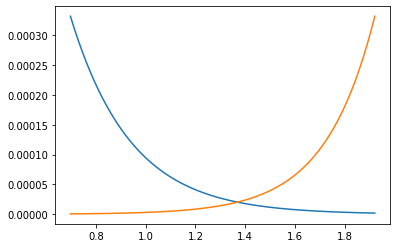

In [387]:
plt.plot(theta_vec,Fpe_1*r_m1,theta_vec,Fpe_2*-r_m2)

In [388]:
eq_theta = theta_vec[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
eq_theta*180/np.pi

78.3983983983984

In [428]:
# Set the amplitude of step inputs
u_1_amp = 0.25
u_2_amp = 0.2

# Generate step inputs to flexor and extensor
time_sim = np.arange(0,duration,step = 1/Fs)
u_1 = np.zeros([int(duration*Fs),1])
u_2 = np.zeros([int(duration*Fs),1])
u_1[int(0.1*Fs):] = u_1_amp
u_2[int(0.1*Fs):] = u_2_amp

In [429]:
theta = eq_theta
dtheta = 0
Lm_1 = Lce_1[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_1 = Lm_1*Lce0_1
Lm_2 = Lce_2[np.argmin(abs(Fpe_1*r_m1-Fpe_2*-r_m2))]
Lm_2 = Lm_2*Lce0_2
x = np.array([theta, dtheta, Lm_1, Lm_2])
dx = np.zeros(4)
x_mat = np.zeros((int(duration*Fs),len(x)))

In [430]:
t0 = time.time()
for t in range(int(duration*Fs)):
    u = np.concatenate((u_1[t],u_2[t]))
    f1 = forward_dynamis(x,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x1 = x + f1*h/2
    f2 = forward_dynamis(x1,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x2 = x + f2*h/2
    f3 = forward_dynamis(x2,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x3 = x + f3*h
    f4 = forward_dynamis(x3,dx,u,I,B,K,Lce0_1,Lce0_2,F0_1,F0_2,Lmax_1,Lmax_2,r_m1,r_m2)
    x = x + (f1+2*f2+2*f3+f4)*h/6
    x_mat[t,:] = x
                           
tf = time.time()
total = tf-t0
print(total)

1.4061744213104248


(68.39839916973527, 107.15453157250326)

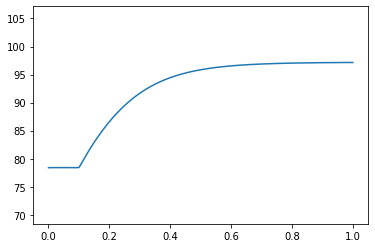

In [431]:
min_angle = np.min(np.rad2deg(x_mat[:,0]))
max_angle = np.max(np.rad2deg(x_mat[:,0]))
plt.plot(time_sim,np.rad2deg(x_mat[:,0]))
plt.ylim([min_angle-10, max_angle+10])

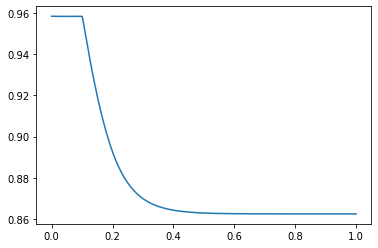

In [427]:
plt.plot(time_sim,x_mat[:,2]/Lce0_1)

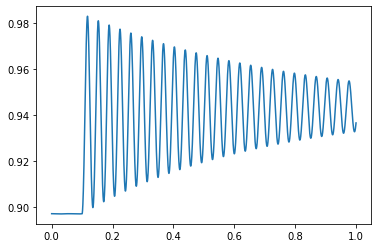

In [300]:
plt.plot(time_sim,x_mat[:,3]/Lce0_2)

In [259]:
Lce = np.linspace(0.5,1.2,1000)
L = Lce/1.2

In [260]:
Fpe = Fpe_function(L,0)

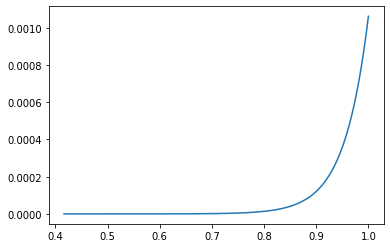

In [261]:
plt.plot(L,Fpe)

In [262]:
Fpe_function(1,0)

0.001062005665686885

In [269]:
c1_pe1 = 23.0*6
k1_pe1 = 0.046
Lr1_pe1 = 1.17
eta = 0.0001
Fpe1 = c1_pe1 * k1_pe1 * np.log(np.exp((1 - Lr1_pe1)/(k1_pe1))+1)

In [270]:
Fpe1

0.15570354642375495